In [63]:
from collect_data import collect_ecos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler

# 1. Get data

In [64]:
ecos_df = collect_ecos()

In [71]:
ecos_df

,TIME,한국은행_기준금리,KOSPI_종가,KOSDAQ_종가,CD_91일,국고채_10년,회사채_3년_AA,KOSPI_거래대금_일평균,KOSDAQ_거래대금_일평균,KOSPI_주가이익비율_3,...,개인_순매수,외국인_순매수_3,투자자_예탁금,파생상품거래_예수금_1,RP,위탁매매_미수금,신용융자_잔고_2,계약금액_일평균_1,거래대금_일평균_CALL_옵션,거래대금_일평균_PUT_옵션
0,200601,3.75,1399.83,690.24,4.15,5.580,5.500,5764974901,2767398234,11.13,...,-1418026,2144056,13125226,4853322,8645650,1648606,539415,17709754,347388,337941
1,200602,4.00,1371.59,682.36,4.25,5.280,5.330,4314643070,2208538818,11.10,...,-295807,-525954,12114613,4752138,8737036,1656679,534412,19284046,340487,372820
2,200603,4.00,1359.60,665.21,4.27,5.420,5.300,3396915531,1881506569,11.00,...,-388993,193995,11248693,4692259,8603517,1234086,509350,17582244,256246,294798
3,200604,4.00,1419.73,685.44,4.33,5.450,5.240,4111860060,2017587690,11.70,...,-1040967,465957,13276411,4702026,8906112,1350981,538352,16698692,326492,283228
4,200605,4.00,1317.70,630.50,4.36,5.200,5.050,3814477431,1623513040,10.85,...,1126551,-3537157,10781390,5094113,8948915,811022,508630,17713026,332488,375055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,202111,1.00,2839.01,965.63,1.17,2.355,2.492,11717785820,12599877645,13.77,...,-1792726,2607320,65982417,11404812,90696849,323269,23452952,24147853,255505,329251
191,202112,1.00,2977.65,1033.98,1.27,2.187,2.410,9919548905,11222767614,12.72,...,-6368816,3398687,67530709,10785489,83396190,321040,23088636,30072196,311706,300854
192,202201,1.25,2663.34,872.87,1.39,2.492,2.632,11282725350,9368232570,12.14,...,4387758,-1461738,70344739,11808123,89550629,302391,21672907,28714128,300928,417528
193,202202,1.25,2699.18,881.07,1.50,2.690,2.873,10950191761,7709877157,12.32,...,470383,798268,63425412,11335916,89976992,248013,20896955,27739423,319891,393760


# 2. Preprocessing

In [69]:
# nan이 있는 행 삭제
ecos_df.dropna(inplace=True)
ecos_df.reset_index(drop=True, inplace=True)

# 칼럼명 내 '(', ')' 기호 -> '[', ']'로 수정
ecos_df_cols_new = list(ecos_df.columns)
for idx, i in enumerate(ecos_df_cols_new):
    temp_name = re.sub('[\( ]', '_', i)
    temp_name = re.sub('[\)\,\-]', '', temp_name)
    ecos_df_cols_new[idx] = temp_name

ecos_df.columns = ecos_df_cols_new

In [70]:
# 칼럼 type numeric으로 수정
ecos_df = ecos_df.apply(pd.to_numeric, errors='coerce')

In [58]:
'''
다음 월(next month)의 종가를 값으로 갖는 새로운 칼럼 만들기
'''
# 기존 칼럼 갯수
column_index = len(ecos_df.columns)

# 새로운 칼럼에 임시로 0.1값 부여(float으로 만들기 위해)
ecos_df.insert(column_index, column='KOSPI_NEW', value=0.1)
#ecos_df.insert(column_index+1, column='KOSDAQ_NEW', value=0.1)

# 새로운 칼럼에 다음 월 종가 기입
for i in range(len(ecos_df)-1):
    ecos_df.loc[i, 'KOSPI_NEW'] = ecos_df.loc[i+1, 'KOSPI_종가']
    #ecos_df.loc[i, 'KOSDAQ_NEW'] = ecos_df.loc[i+1, 'KOSDAQ_종가']

# 마지막 행 삭제(새로운 칼럼에 값이 없기 때문)
ecos_df.drop(labels=ecos_df.index[-1], axis='index', inplace=True)

# 코스피/코스닥 칼럼명 변경
ecos_df.rename(columns={'KOSPI_종가':'KOSPI', 'KOSDAQ_종가':'KOSDAQ'}, inplace=True) 

In [59]:
# 전월 대비 증가했으면 1, 감소했으면 0부여
for i in range(len(ecos_df)):
    if ecos_df.loc[i, 'KOSPI'] <= ecos_df.loc[i, 'KOSPI_NEW']:
        ecos_df.loc[i, 'KOSPI_BINARY'] = 1
    else:
        ecos_df.loc[i, 'KOSPI_BINARY'] = 0

    # if ecos_df.loc[i, 'KOSDAQ'] <= ecos_df.loc[i, 'KOSDAQ_NEW']:
    #     ecos_df.loc[i, 'KOSDAQ_BINARY'] = 1
    # else:
    #     ecos_df.loc[i, 'KOSDAQ_BINARY'] = 0

# BINARY 칼럼 type을 int로
ecos_df = ecos_df.astype({'KOSPI_BINARY':'int'})
#ecos_df = ecos_df.astype({'KOSPI_BINARY':'int', 'KOSDAQ_BINARY':'int'})

In [60]:
# 전년 동기 대비 값으로 변경하기
ecos_df_cols = list(ecos_df.columns)
not_yoy_cols = ['TIME', '한국은행_기준금리', 'KOSPI_NEW', 'KOSPI_BINARY']

for c in ecos_df_cols:
    if c in not_yoy_cols:
        continue
    else:
        ecos_df[f'{c}_yoy'] = None
        for i in range(12, len(ecos_df)):
            yoy_value = (ecos_df.loc[i, c] - ecos_df.loc[i-12, c])/ecos_df.loc[i-12, c]
            ecos_df.loc[i, f'{c}_yoy'] = yoy_value
erase_cols = ecos_df_cols
for i in not_yoy_cols:
    erase_cols.remove(i)
ecos_df = ecos_df.loc[12: ]
ecos_df = ecos_df[ecos_df.columns.difference(erase_cols)]
ecos_df.reset_index(drop=True, inplace=True)

# 칼럼 type numeric으로 수정
ecos_df = ecos_df.apply(pd.to_numeric, errors='coerce')

ecos_df

#ecos_df.loc[12:,:].isna().any().sum()

,CD_91일_yoy,KOSDAQ_yoy,KOSDAQ_거래대금_일평균_yoy,KOSPI_BINARY,KOSPI_NEW,KOSPI_yoy,KOSPI_거래대금_일평균_yoy,KOSPI_상장주식_회전율_1_yoy,KOSPI_주가이익비율_3_yoy,RP_yoy,...,계약금액_일평균_1_yoy,국고채_10년_yoy,기관투자자_순매수_yoy,신용융자_잔고_2_yoy,외국인_순매수_3_yoy,위탁매매_미수금_yoy,투자자_예탁금_yoy,파생상품거래_예수금_1_yoy,한국은행_기준금리,회사채_3년_AA_yoy
0,0.185542,-0.164972,-0.360516,1,1417.34,-0.028289,-0.552036,-0.616379,-0.027853,1.287185,...,-0.118548,-0.096774,0.154839,-0.114678,-0.976474,-0.561853,-0.349663,0.025273,4.50,-0.032727
1,0.164706,-0.119336,-0.181230,1,1452.55,0.033355,-0.222730,-0.441006,0.018018,1.256692,...,-0.236126,-0.051136,-1.462281,0.450267,-3.367340,-0.511084,-0.196269,0.063180,4.50,-0.009381
2,0.156909,-0.024383,0.090447,1,1542.24,0.068366,-0.072941,-0.237811,0.056364,1.434499,...,0.026705,-0.088561,-0.227173,1.500642,-6.584845,-0.317329,-0.119039,0.040888,4.50,-0.018868
3,0.143187,-0.013947,0.128743,1,1700.91,0.086291,0.087658,0.074151,0.129060,1.522788,...,-0.084837,-0.069725,-5.736884,4.055399,4.883884,-0.548216,-0.143822,0.144804,4.50,0.019084
4,0.155963,0.186154,0.150899,1,1743.60,0.290817,0.326716,0.576626,0.333641,1.551841,...,0.017032,0.003846,-1.377509,8.570310,-1.068953,-0.895807,0.222093,0.216704,4.50,0.087129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0.714286,0.251914,0.072909,0,2839.01,0.310315,0.083598,-0.188119,-0.476680,0.051279,...,0.384391,0.591904,-2.051014,0.462704,8.870111,0.022648,0.212404,0.023711,0.75,0.028138
178,0.772727,0.089741,0.023601,1,2977.65,0.095576,-0.231584,-0.481922,-0.558229,0.016705,...,-0.017544,0.462733,-0.353319,0.307289,-0.477891,-0.098879,0.071358,0.047069,1.00,0.109034
179,0.924242,0.067698,-0.273040,0,2663.34,0.036256,-0.454940,-0.603985,-0.568375,-0.009757,...,-0.129734,0.305672,-2.420740,0.201197,-2.937952,-0.338707,0.030646,-0.099708,1.00,0.090005
180,1.044118,-0.060147,-0.400189,1,2699.18,-0.105124,-0.573880,-0.617289,-0.603138,-0.005562,...,-0.318985,0.439630,-0.844666,0.031362,-0.724182,-0.224517,0.034220,-0.087273,1.25,0.228185


# 3. 스케일링

In [61]:
'''
22.04.28. 추가 작업
- 사유: 모델링 중 스케일링이 안 되어 있음을 발견
- 작업 내용: ecos_df를 상관분석 하기 전에 스케일링
- 유의점: py에서는 return에 k.
'''

ecos_df_cols = list(ecos_df.columns)
# 각 값들 소수점 둘째자리에서 반올림
ecos_df = ecos_df.apply(lambda x : round(x, 2))

# 스케일링 진행
scaler = MinMaxScaler()
scaler.fit(ecos_df)
'''
scaler에서 inf값 때문에 오류가 난다면, 해당 지표는 삭제하는 게 좋다고 생각한다. 결측값 처리하기가 참 애매하다. 그냥 빼는 게 낫다
 -> 신용 대주 잔고 삭제.
'''
ecos_df = scaler.transform(ecos_df)

# 데이터프레임화
ecos_df = pd.DataFrame(ecos_df)
ecos_df.columns = ecos_df_cols

In [62]:
ecos_df

,CD_91일_yoy,KOSDAQ_yoy,KOSDAQ_거래대금_일평균_yoy,KOSPI_BINARY,KOSPI_NEW,KOSPI_yoy,KOSPI_거래대금_일평균_yoy,KOSPI_상장주식_회전율_1_yoy,KOSPI_주가이익비율_3_yoy,RP_yoy,...,계약금액_일평균_1_yoy,국고채_10년_yoy,기관투자자_순매수_yoy,신용융자_잔고_2_yoy,외국인_순매수_3_yoy,위탁매매_미수금_yoy,투자자_예탁금_yoy,파생상품거래_예수금_1_yoy,한국은행_기준금리,회사채_3년_AA_yoy
0,0.475610,0.353846,0.076696,1.0,0.158624,0.358333,0.005435,0.029915,0.247826,0.844311,...,0.197802,0.354545,0.103336,0.043536,0.301901,0.151786,0.015075,0.320000,0.842105,0.435294
1,0.457317,0.384615,0.129794,1.0,0.174387,0.408333,0.095109,0.106838,0.269565,0.826347,...,0.131868,0.400000,0.099947,0.080475,0.297643,0.174107,0.090452,0.360000,0.842105,0.458824
2,0.457317,0.461538,0.209440,1.0,0.214541,0.441667,0.135870,0.192308,0.286957,0.928144,...,0.280220,0.363636,0.102537,0.149736,0.291923,0.258929,0.130653,0.333333,0.842105,0.447059
3,0.445122,0.469231,0.221239,1.0,0.285577,0.458333,0.179348,0.324786,0.317391,0.982036,...,0.219780,0.381818,0.090938,0.318602,0.312343,0.156250,0.120603,0.466667,0.842105,0.494118
4,0.457317,0.623077,0.227139,1.0,0.304690,0.625000,0.244565,0.542735,0.404348,1.000000,...,0.274725,0.445455,0.100116,0.616095,0.301741,0.000000,0.301508,0.573333,0.842105,0.576471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0.792683,0.669231,0.203540,0.0,0.795102,0.641667,0.176630,0.213675,0.052174,0.101796,...,0.472527,0.981818,0.098705,0.081135,0.319453,0.410714,0.296482,0.306667,0.052632,0.505882
178,0.829268,0.546154,0.188791,1.0,0.857171,0.466667,0.092391,0.089744,0.017391,0.083832,...,0.252747,0.863636,0.102284,0.071240,0.302792,0.357143,0.226131,0.346667,0.105263,0.600000
179,0.920732,0.530769,0.103245,0.0,0.716455,0.416667,0.032609,0.038462,0.013043,0.065868,...,0.192308,0.727273,0.097927,0.063984,0.298409,0.250000,0.206030,0.146667,0.105263,0.576471
180,0.993902,0.430769,0.064897,1.0,0.732501,0.291667,0.000000,0.029915,0.000000,0.065868,...,0.087912,0.845455,0.101252,0.052770,0.302365,0.303571,0.206030,0.160000,0.157895,0.741176


# 4. Correlation analysis

In [8]:
# 상관분석
ecos_corr = ecos_df.corr()

C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 54217 (\N{H

<AxesSubplot:>

C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\loven\Anaconda3\envs\prediction\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from c

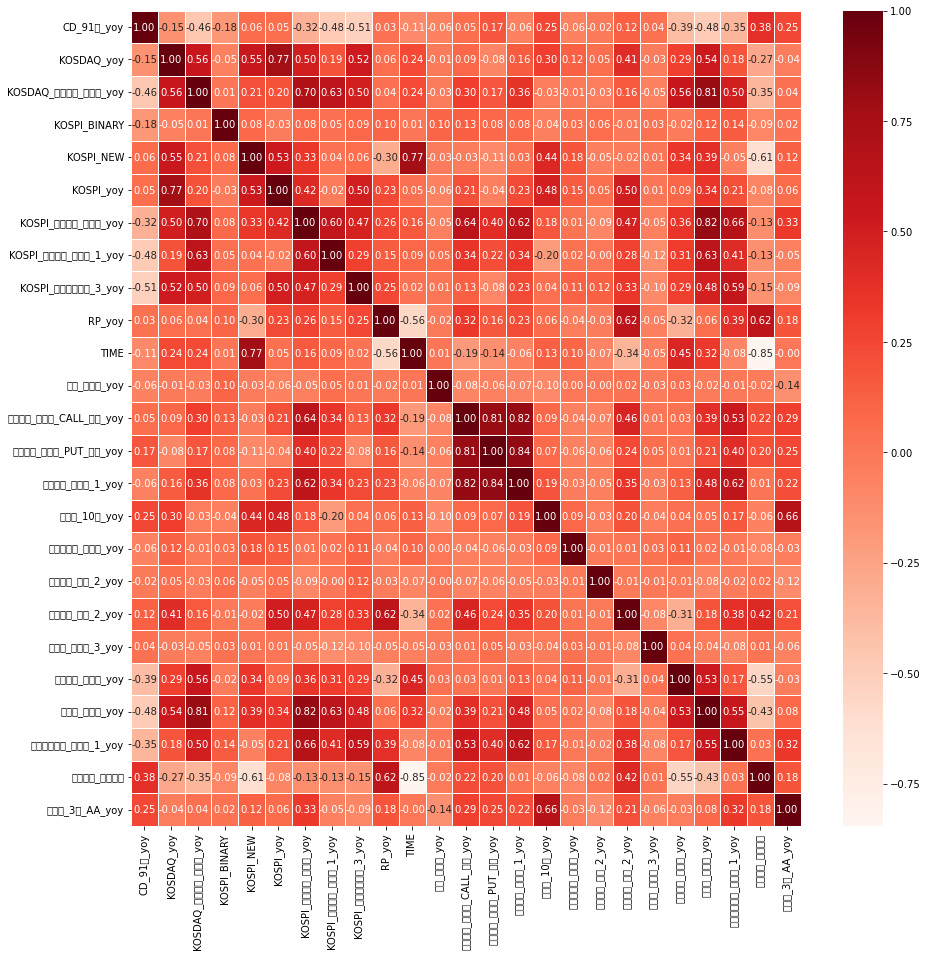

In [9]:
## heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(data = ecos_corr, annot=True, fmt='.2f', linewidths=.5, cmap='Reds')

In [10]:
'''
높은 상관관계가 있는 칼럼 추출
'''

threshholds = 0.2

# 필수 포함 feature: based on 도메인지식
nece_ftrs = ['한국은행_기준금리', 'KOSPI_yoy', '국고채_10년_yoy', 'KOSPI_주가이익비율_3_yoy', 'KOSPI_BINARY']

kospi_corr = ecos_corr['KOSPI_NEW']
#kosdaq_corr = ecos_corr['KOSDAQ_NEW']

# 불필요한 칼럼 삭제
kospi_corr.drop(labels=['TIME', 'KOSPI_NEW'], axis='index', inplace=True)
#kosdaq_corr.drop(labels=['TIME', 'KOSPI_NEW', 'KOSDAQ_NEW'], axis='index', inplace=True)

# threshholds 기준에 부합하는 칼럼 출력
kospi_ftrs = list(kospi_corr[(kospi_corr>=threshholds) | (kospi_corr<=-threshholds)].keys())
#kosdaq_ftrs = kosdaq_corr[(kosdaq_corr>=0.3) | (kosdaq_corr<=-0.3)].keys()

# 필수 feature가 없을 시 추가
for f in nece_ftrs:
    if f not in kospi_ftrs:
        kospi_ftrs.append(f)

In [11]:
# 상관분석 결과 바탕으로 데이터셋 수정
#kospi_ftrs.insert(0, 'TIME')
#kospi_ftrs.extend(['KOSPI_NEW'])
ecos_df = ecos_df[kospi_ftrs]

In [12]:
ecos_df

,TIME,KOSDAQ_yoy,KOSDAQ_거래대금_일평균_yoy,KOSPI_yoy,KOSPI_거래대금_일평균_yoy,RP_yoy,국고채_10년_yoy,위탁매매_미수금_yoy,투자자_예탁금_yoy,한국은행_기준금리,KOSPI_주가이익비율_3_yoy,KOSPI_BINARY,KOSPI_NEW
0,200701,-0.164972,-0.360516,-0.028289,-0.552036,1.287185,-0.096774,-0.561853,-0.349663,4.50,-0.027853,1,1417.34
1,200702,-0.119336,-0.181230,0.033355,-0.222730,1.256692,-0.051136,-0.511084,-0.196269,4.50,0.018018,1,1452.55
2,200703,-0.024383,0.090447,0.068366,-0.072941,1.434499,-0.088561,-0.317329,-0.119039,4.50,0.056364,1,1542.24
3,200704,-0.013947,0.128743,0.086291,0.087658,1.522788,-0.069725,-0.548216,-0.143822,4.50,0.129060,1,1700.91
4,200705,0.186154,0.150899,0.290817,0.326716,1.551841,0.003846,-0.895807,0.222093,4.50,0.333641,1,1743.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,202108,0.224099,-0.194160,0.375338,-0.041712,0.078182,0.387473,-0.112465,0.149822,0.75,-0.318352,0,3068.82
176,202109,0.182892,-0.237357,0.318284,-0.009459,0.055961,0.374000,0.319498,0.268488,0.75,-0.470313,0,2970.68
177,202110,0.251914,0.072909,0.310315,0.083598,0.051279,0.591904,0.022648,0.212404,0.75,-0.476680,0,2839.01
178,202111,0.089741,0.023601,0.095576,-0.231584,0.016705,0.462733,-0.098879,0.071358,1.00,-0.558229,1,2977.65
